# Imports

In [1]:
from keras import layers, callbacks, utils, metrics, Sequential, optimizers, initializers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score

# Constants

In [2]:
# Constantes
BATCH_SIZE = 64
IMG_HEIGHT = 256
IMG_WIDTH = 256
LEARNING_RATE = 1e-5

DATASET_PATH = "../../cats_and_dogs"
DATASET_TRAIN_PATH = f"{DATASET_PATH}/train"
DATASET_VAL_PATH = f"{DATASET_PATH}/validation"

NUM_CLASSES = 2

SEED = 7654321

VAL_TEST_RATIO = 0.5

MAX_EPOCHS = 100

WEIGHTS_FILE_EXT = "weights.h5"
HYPERPARAMS_FILE_EXT = "hyperparams.json"

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = callbacks.EarlyStopping(monitor="val_loss", patience=5)

INITIALIZER = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)
GLOROT_UNIFORM_INITIALIZER = initializers.GlorotUniform(seed=SEED)

DEFAULT_LOSS = "binary_crossentropy"
DEFAULT_OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)
DEFAULT_METRICS = ["accuracy", metrics.F1Score]

2025-03-29 17:44:31.534295: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-29 17:44:31.534329: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-29 17:44:31.534332: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1743270271.534660 1033189 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743270271.534898 1033189 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Dataset load

In [3]:
train_ds = utils.image_dataset_from_directory(
    DATASET_TRAIN_PATH,
    labels="inferred",
    label_mode="binary",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    verbose=False,
)

val_ds, test_ds = utils.image_dataset_from_directory(
    DATASET_VAL_PATH,
    labels="inferred",
    label_mode="binary",
    validation_split=VAL_TEST_RATIO,
    subset="both",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    verbose=False,
)
labels = train_ds.class_names

# load the datasets into memory - once loaded, the order of the batches will no longer change
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()


Using 500 files for training.
Using 500 files for validation.


# Model with a sequence of convolutional layer and pooling layer

In [4]:
conv_pool_seq_model = Sequential(
    [
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(160, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(192, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        layers.Conv2D(224, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
        layers.MaxPooling2D(),

        # Hidden layer
        layers.Dense(352, activation="relu", kernel_initializer=INITIALIZER),
        layers.Dense(384, activation="relu", kernel_initializer=INITIALIZER),

        # Classifier
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid", kernel_initializer=INITIALIZER)
    ], name="conv_pool_seq_model"
)
conv_pool_seq_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["accuracy", metrics.F1Score]
)

## Model summary

In [5]:
conv_pool_seq_model.summary()

Model: "conv_pool_seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 160)    │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 192)      │       276,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 224)      │       387,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2, 2, 352)      │        79,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2, 2, 384)      │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,241 (4.77 MB)

 Trainable params: 1,250,241 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

## Model fit

In [6]:
BEST_CONV_POOL_SEQ_MODEL = f"../../models/{conv_pool_seq_model.name}.{WEIGHTS_FILE_EXT}"

conv_pool_seq_model_checkpoint = callbacks.ModelCheckpoint(
    filepath=BEST_CONV_POOL_SEQ_MODEL,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

conv_pool_seq_model_history = conv_pool_seq_model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=val_ds,
    callbacks=[conv_pool_seq_model_checkpoint, EARLY_STOPPING],
)

Epoch 1/100


2025-03-29 17:44:32.458390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.4784 - f1_score: 0.6532 - loss: 1.4532 - val_accuracy: 0.5640 - val_f1_score: 0.6649 - val_loss: 0.8659
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.5502 - f1_score: 0.6532 - loss: 0.8448 - val_accuracy: 0.5600 - val_f1_score: 0.6649 - val_loss: 0.7601
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.5804 - f1_score: 0.6532 - loss: 0.7436 - val_accuracy: 0.5620 - val_f1_score: 0.6649 - val_loss: 0.7363
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.6055 - f1_score: 0.6532 - loss: 0.6991 - val_accuracy: 0.5800 - val_f1_score: 0.6649 - val_loss: 0.7255
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.6352 - f1_score: 0.6532 - loss: 0.6689 - val_accuracy: 0.5880 - val_f1_score: 0.6649 - val_loss: 0.7126
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.6462 - f1_score: 0.6532 - loss: 0.6442 - val_accuracy: 0.6020 - val_f1_score: 0.6649 - val

## Quality of the model

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step

2025-03-29 17:46:51.151019: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Falhou em 243 amostras num total de 500 imagens de flores
Test Dataset Metrics:
Taxa de acertos: 51.40 %
Precisão: 51.0000 %
Cobertura: 61.4458 %
F1 Score: 55.7377 %


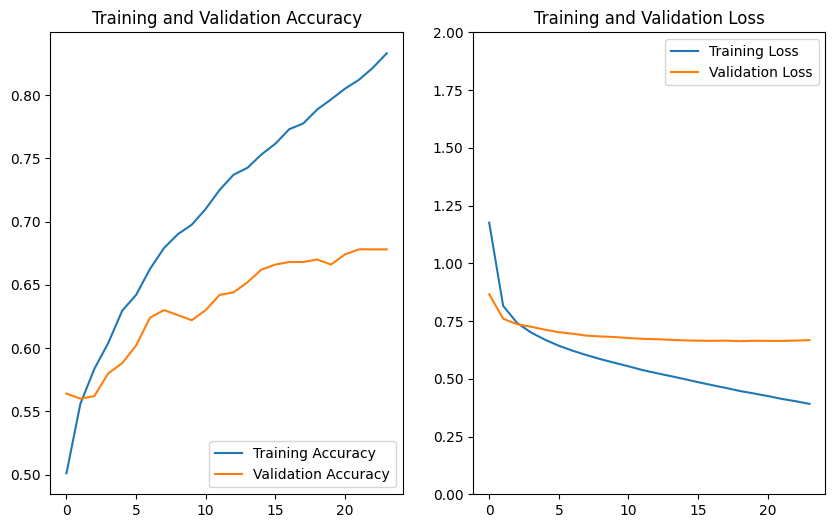

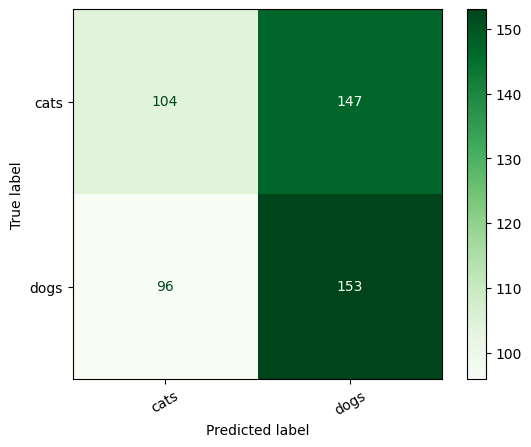

In [7]:
# carregar o melhor modelo encontrado durante o treino
conv_pool_seq_model.load_weights(BEST_CONV_POOL_SEQ_MODEL)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Make predictions
output_pred = conv_pool_seq_model.predict(test_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

n_misses = np.count_nonzero(y_pred != y_true.flatten())
n_preds = y_pred.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print(
    "Falhou em {:d} amostras num total de {:d} imagens de flores".format(
        n_misses, n_preds
    )
)

# Calculate precision, recall, and F1 score
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"Test Dataset Metrics:")
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))
print(f"Precisão: {test_precision * 100:.4f} %")
print(f"Cobertura: {test_recall * 100:.4f} %")
print(f"F1 Score: {test_f1 * 100:.4f} %")


# gerar gráficos e matriz de confusão
cm = confusion_matrix(y_true, y_pred)

acc = conv_pool_seq_model_history.history["accuracy"]
val_acc = conv_pool_seq_model_history.history["val_accuracy"]
loss = conv_pool_seq_model_history.history["loss"]
val_loss = conv_pool_seq_model_history.history["val_loss"]
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylim(0, 2)
plt.title("Training and Validation Loss")

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Greens", xticks_rotation=30)
plt.show()